In [1]:
# Python3.5
import numpy as np
from eccentric.synthetic import SyntheticFlares, HotJupiterHost

### Create 60 Hot Jupiter hosts with time series observations, and instrinsic and SPI flares

Creating the following data set:

- 60 Hot Jupiters
- typical observation time 45 days
- a third each: 1 min, 2 min, and 30 min cadence
- up to 22 per day, at least 1
- an SPI flare occurs per period if period is below 4 days

In [2]:
n = 20 * 3
periods = np.random.rand(n) * 25. + 0.5
observation_deltats = np.random.rand(n) * 90
cadences = [60] * int(n/3) + [2] * int(n/3) + [30] * int(n/3) 
flares_per_days = 10 / periods +1# maximum 22 flares per day, at least 1
sizes = np.zeros_like(periods)
sizes[np.where(periods < 4.)] = 1
params = list(zip(periods, observation_deltats, cadences, flares_per_days, sizes))

In [3]:
for i, (p, ot, c, fpd, s) in enumerate(params):
    sf = SyntheticFlares(hjhost=HotJupiterHost(period=p), #in days
                         observation_deltat=ot, # in days
                         cadence=c, #observations per hour
                         flares_per_day=fpd) #in days^-1

    sf.generate_synthetic_flares(model="Gauss",
                                 size=int(s), # number of SPI flares per periastron passage
                                 width=p/20., # in days (standard deviation)
                                 phase=0.7) # default value, can be chosen from 0 to 1
    sf.write_out_synthetic_flare_table(path="synth/{:03d}_eccentric_hjhost_with_flares.csv".format(i))

### Stack and view histogram of all generated data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
paths = ! ls synth/*.csv

In [6]:
allf = pd.DataFrame()
for path in paths:
    df = pd.read_csv(path, skiprows=12)
    with open(path, 'r') as file:
        file.readline()
        file.readline()
        period = float(file.readline()[1:])
        file.readline()
        file.readline()
        first_periastron = float(file.readline()[1:])
    df["stacked_and_scaled"] = ((df.peak_time - first_periastron) % period) / period
    allf = pd.concat([allf, df])

In [7]:
allf.groupby("source").stacked_and_scaled.count()

source
ambiguous      13
intrinsic    6383
spi           173
Name: stacked_and_scaled, dtype: int64

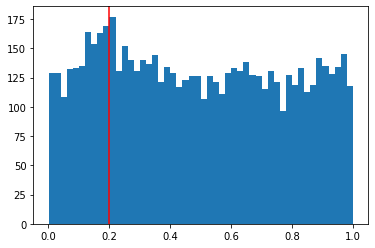

In [8]:
plt.hist(allf.stacked_and_scaled, bins=50)
plt.axvline(0.2, c="r");    